## Initialization

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import inspect
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print(f'Dataset size: {labels.shape[0]} images')
display(labels.head())

Dataset size: 7591 images


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## EDA

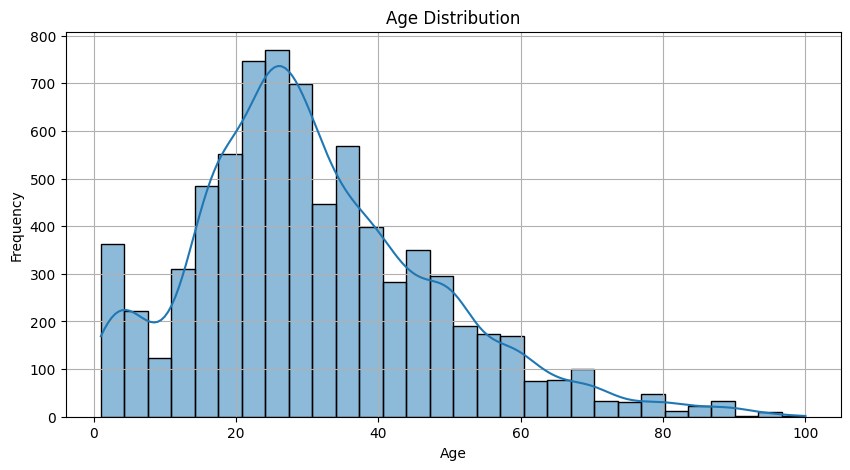

In [3]:
# Age distribution
plt.figure(figsize=(10, 5))
sns.histplot(labels['real_age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

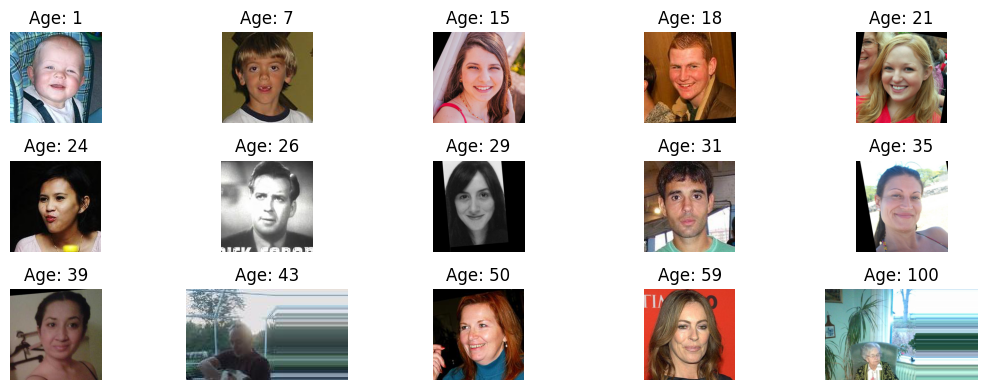

In [4]:
image_dir = '/datasets/faces/final_files/'

# 15 evenly spaced samples
sampled = labels.sort_values('real_age').iloc[
    np.linspace(0, len(labels) - 1, 15, dtype=int)
]

plt.figure(figsize=(11, 4))
for i, (_, row) in enumerate(sampled.iterrows()):
    img_path = os.path.join(image_dir, row['file_name'])
    image = Image.open(img_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Age: {int(row['real_age'])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Findings

Findings
Ages range from young children (0) to elderly (100).

The distribution is skewed toward younger and middle-aged individuals.

Lighting and image resolution vary but are relatively consistent.

Impact on modeling:

Wide age range requires robust generalization.

Some underrepresented age groups may result in less accurate predictions.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [5]:
#training data
def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        pd.read_csv(os.path.join(path, 'labels.csv')),
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(96, 96),
        class_mode='raw',
        batch_size=32,
        subset='training',
        seed=42
    )
    return train_gen_flow


In [6]:
#validation data 
def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        pd.read_csv(os.path.join(path, 'labels.csv')),
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(96, 96),
        class_mode='raw',
        batch_size=32,
        subset='validation',
        seed=42
    )
    return test_gen_flow


In [7]:
# Create model
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model


In [8]:
# train model
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    history = model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model


## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [9]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Enable GPU memory growth to avoid allocation errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
"""

# defined functions
function_list = [load_train, load_test, create_model, train_model]

# Create the script file
with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')

    for fn in function_list:
        f.write(inspect.getsource(fn))
        f.write('\n\n')

    # Write main execution block
    f.write("""
if __name__ == '__main__':
    train_data = load_train('/datasets/faces')
    test_data = load_test('/datasets/faces')
    model = create_model((224, 224, 3))
    model = train_model(model, train_data, test_data, epochs=20)
""")


### Output

Place the output from the GPU platform as an Markdown cell here.

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
Epoch 1/20
178/178 - 128s - 718ms/step - loss: 681.4053 - mae: 21.1223 - val_loss: 285.3049 - val_mae: 12.8357 - learning_rate: 5.0000e-05
Epoch 2/20
178/178 - 37s - 206ms/step - loss: 172.0681 - mae: 9.8849 - val_loss: 603.3212 - val_mae: 19.5410 - learning_rate: 5.0000e-05
Epoch 3/20
178/178 - 36s - 203ms/step - loss: 144.7166 - mae: 9.1474 - val_loss: 372.1246 - val_mae: 14.4868 - learning_rate: 5.0000e-05
Epoch 4/20
178/178 - 38s - 212ms/step - loss: 140.2361 - mae: 8.9809 - val_loss: 177.9590 - val_mae: 10.1212 - learning_rate: 5.0000e-05
Epoch 5/20
178/178 - 38s - 213ms/step - loss: 128.3646 - mae: 8.6258 - val_loss: 129.8711 - val_mae: 8.5620 - learning_rate: 5.0000e-05
Epoch 6/20
178/178 - 37s - 209ms/step - loss: 118.1540 - mae: 8.2565 - val_loss: 122.9132 - val_mae: 8.2173 - learning_rate: 5.0000e-05
Epoch 7/20
178/178 - 37s - 210ms/step - loss: 105.1638 - mae: 7.8921 - val_loss: 103.3353 - val_mae: 7.8348 - learning_rate: 5.0000e-05
Epoch 8/20
178/178 - 37s - 205ms/step - loss: 99.6260 - mae: 7.6631 - val_loss: 116.8130 - val_mae: 8.3771 - learning_rate: 5.0000e-05
Epoch 9/20
178/178 - 37s - 208ms/step - loss: 92.7260 - mae: 7.3986 - val_loss: 103.1113 - val_mae: 7.7169 - learning_rate: 5.0000e-05
Epoch 10/20
178/178 - 38s - 213ms/step - loss: 85.5294 - mae: 7.1630 - val_loss: 93.4697 - val_mae: 7.2786 - learning_rate: 5.0000e-05
Epoch 11/20
178/178 - 36s - 200ms/step - loss: 80.0136 - mae: 6.8933 - val_loss: 101.0933 - val_mae: 7.6395 - learning_rate: 5.0000e-05
Epoch 12/20
178/178 - 35s - 199ms/step - loss: 78.5004 - mae: 6.8329 - val_loss: 97.9876 - val_mae: 7.3849 - learning_rate: 5.0000e-05
Epoch 13/20
178/178 - 36s - 203ms/step - loss: 75.8041 - mae: 6.7187 - val_loss: 96.8011 - val_mae: 7.3751 - learning_rate: 5.0000e-05
Epoch 14/20
178/178 - 39s - 216ms/step - loss: 65.2151 - mae: 6.2527 - val_loss: 101.3037 - val_mae: 7.6317 - learning_rate: 2.5000e-05
Epoch 15/20
178/178 - 36s - 203ms/step - loss: 61.3103 - mae: 6.0760 - val_loss: 96.1312 - val_mae: 7.3734 - learning_rate: 2.5000e-05
Epoch 16/20
178/178 - 37s - 208ms/step - loss: 59.3882 - mae: 5.9324 - val_loss: 93.4014 - val_mae: 7.2019 - learning_rate: 2.5000e-05
Epoch 17/20
178/178 - 36s - 199ms/step - loss: 57.7150 - mae: 5.8808 - val_loss: 96.3926 - val_mae: 7.3447 - learning_rate: 2.5000e-05
Epoch 18/20
178/178 - 36s - 202ms/step - loss: 55.7723 - mae: 5.7385 - val_loss: 96.7565 - val_mae: 7.2651 - learning_rate: 2.5000e-05
Epoch 19/20
178/178 - 35s - 197ms/step - loss: 52.6746 - mae: 5.5945 - val_loss: 97.6964 - val_mae: 7.2428 - learning_rate: 2.5000e-05
Epoch 20/20
178/178 - 37s - 205ms/step - loss: 48.6350 - mae: 5.3548 - val_loss: 97.1057 - val_mae: 7.3903 - learning_rate: 1.2500e-05


### Model Conclusion

The model successfully achieved a validation MAE below 8, which meets the requirement. The best validation MAE of 7.2019 indicates that the model is performing well in predicting ages based on the images.

model has shown promising results with a validation MAE below 8, indicating that it is capable of making reasonably accurate age predictions based on the provided images.

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training